Jupyter notebook for loading the car profiles and their corresponding frames, and to run shape optimization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import optim_utils
import torch
import matplotlib
import os

### Visualization functions

In [2]:
def visu_pressure_around(pressure , sdf):
    pressure = np.array(pressure).reshape(list(shape))
    pressure -= np.min(pressure)
    pressure /= np.max(pressure)
    rgba = matplotlib.colormaps['plasma'](pressure)
    mask = optim_utils.dirac_gauss(3/shape[1])(sdf.reshape(list(shape)))
    mask /= torch.max(mask)
    rgba[..., 3] = mask.cpu()
    
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.imshow(rgba, origin= 'lower')
    plt.title("Pressure around contour")
    plt.axis('off')
    
def visu_vorticity(vort):
    mx = 200
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.imshow(vort, origin= 'lower', cmap = 'seismic', vmin = -mx, vmax = mx)
    plt.title("Vorticity")
    plt.axis("off")
    
def visu_contour(sdf):
    hmax , wmin , wmax = 100 , 30 , 300
    restricted_sdf = sdf[:hmax , wmin:wmax]
    restricted_shape = (hmax , wmax-wmin)
    fig, ax = plt.subplots(figsize=(8, 4))
    cs = ax.contour(restricted_sdf.reshape(list(restricted_shape)).detach().cpu(), levels = [0], linewidths = 1, colors = 'black')
    plt.axis("off")


### Load dataset and one custom car profile

You can download our dataset here: https://repo-sam.inria.fr/d3/car_physical_simulations/code_8_2013_smooth_pressure_sdf_v.npz
and place it in the "./data/" folder

In [3]:
file_name = './data/code_8_2013_smooth_pressure_sdf_v.npz'
dataset = np.load(file_name)
pixels = dataset['pixels']
thetas = dataset['thetas']

In [4]:
custom_idx = 17
frame = pixels[custom_idx]

Retrieve channels

In [5]:
vel = torch.Tensor(frame[:, :, 2:])
sdf = torch.Tensor(frame[:, :, 1])
pressure = torch.Tensor(frame[:, :, 0])
shape = pressure.shape
vort = optim_utils.numerical_vorticity(vel.reshape(list(shape)+[2]), 1/shape[1])[0][0]
shape = vel.shape[:2]

### Visualize the frame

TODO:
visu data
puis inference sur theta
puis inference sur theta opti

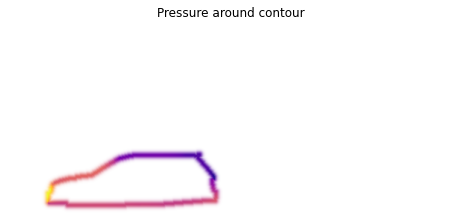

In [6]:
visu_pressure_around(pressure , sdf)

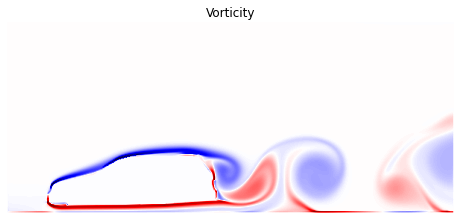

In [7]:
visu_vorticity(vort)

## Shape optimization

Load the inputs for the networks

In [8]:
import sys
sys_path = sys.path.copy()
sys.path.append('./physics_learning')

import network_io
import data_processing_
# import encoder_io

sys.path = sys_path
coords = data_processing_.get_mgrid(shape).cuda()

Load networks

In [9]:
path_to_networks = './physics_learning/select_model/best/'
net_sdf = network_io.load_network(os.path.join(path_to_networks, 'sdf')).cuda()
net_pressure = network_io.load_network(os.path.join(path_to_networks, 'pressure')).cuda()
net_vel = network_io.load_network(os.path.join(path_to_networks, 'vel')).cuda()


### Drag coefficient

In [10]:
theta = torch.Tensor(thetas[custom_idx]).unsqueeze(0).cuda()

run shape optimization

In [12]:
optimization_coefficient = "drag"

lr = 0.05
max_iter = 5
idx = 17
beta = 0
optim_lr_decay = 0.9
optim_change_tol = 1e-4
list_thetas , loss_history = optim_utils.run_optim(optimization_coefficient, idx , lr , beta , optim_lr_decay , max_iter , optim_change_tol , thetas , shape , net_sdf , net_pressure , net_vel)

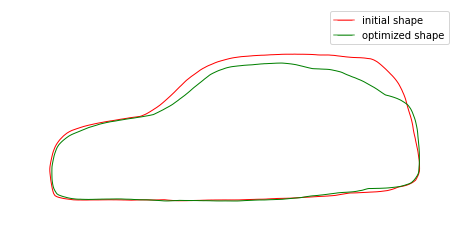

In [13]:
optim_utils.visu_contour(list_thetas , coords , net_sdf)

C:\Users\nrosset\Anaconda3\envs\implicit_representation\lib\site-packages\ipykernel_launcher.py:5: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  """


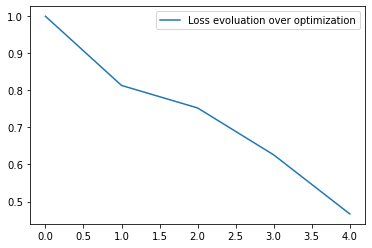

In [25]:
ax = plt.subplot()
mm = ax.plot(loss_history)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles , labels=("Loss evoluation over optimization",))
plt.show()

Since our optimization is based on a surrogate model, it is useful to visualize the inferences of our network to get insights about the process: 

In [13]:
grid_init = data_processing_.get_multiple_mgrid(list_thetas[0], coords)[0]
grid_final = data_processing_.get_multiple_mgrid(list_thetas[-1], coords)[0]

pressure_init = net_pressure(grid_init, unnormalize = True).detach().cpu()
sdf_init = net_sdf(grid_init, unnormalize = True).detach().cpu()
pressure_final = net_pressure(grid_final, unnormalize = True).detach().cpu()
sdf_final = net_sdf(grid_final, unnormalize = True).detach().cpu()

Let's watch the pressure around the contour for the initial latent code

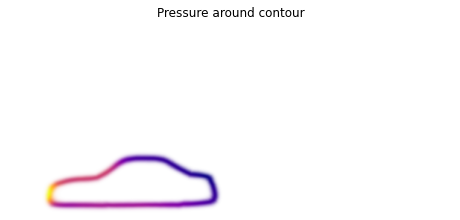

In [14]:
visu_pressure_around(pressure_init , sdf_init)

And the one for the optimized latent code:

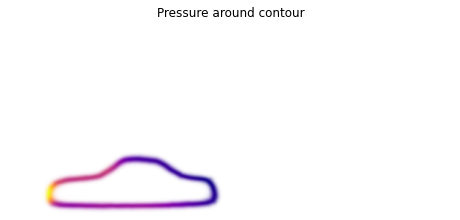

In [15]:
visu_pressure_around(pressure_final , sdf_final)

In [ ]:
ax = plt.subplot()

mm = ax.plot(loss_history)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles , labels=("Loss evoluation over optimization",))
plt.show()

### Vorticity coefficient

In [46]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = (int(w/2), int(h/2))
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [47]:
optimization_coefficient = "vorticity"

lr = 0.05
max_iter = 5
idx = 650
beta = 0
optim_lr_decay = 0.9
optim_change_tol = 1e-4

mask = torch.Tensor(create_circular_mask(256, 600, center=[350,150], radius=40))

list_thetas , losses_history = optim_utils.run_optim(optimization_coefficient, idx , lr , beta , optim_lr_decay , max_iter , optim_change_tol , thetas , shape , net_sdf , net_pressure , net_vel , vort_mask=mask)

The mask in which we eant the vorticity to decrease

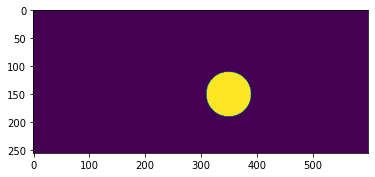

In [48]:
plt.imshow(mask)

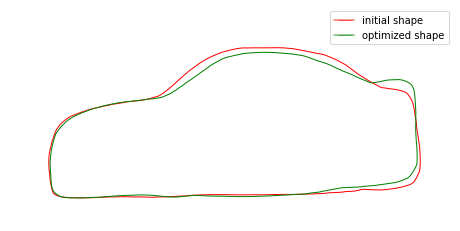

In [49]:
optim_utils.visu_contour(list_thetas , coords , net_sdf)

Eventually, the evolution of the loss during optimization:

C:\Users\nrosset\Anaconda3\envs\implicit_representation\lib\site-packages\ipykernel_launcher.py:5: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  """


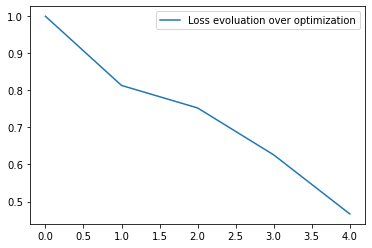

In [50]:
ax = plt.subplot()

mm = ax.plot(loss_history)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles , labels=("Loss evoluation over optimization",))
plt.show()

In [51]:
grid_init = data_processing_.get_multiple_mgrid(list_thetas[0], coords)[0]
grid_final = data_processing_.get_multiple_mgrid(list_thetas[-1], coords)[0]

vel_init = net_vel(grid_init, unnormalize = True).detach().cpu()
vort_init = optim_utils.numerical_vorticity(vel_init.reshape(list(shape)+[2]), 1/shape[1])[0][0]
vel_final = net_vel(grid_final, unnormalize = True).detach().cpu()
vort_final = optim_utils.numerical_vorticity(vel_final.reshape(list(shape)+[2]), 1/shape[1])[0][0]

Let's watch the infered vorticity field for the initial latent code:

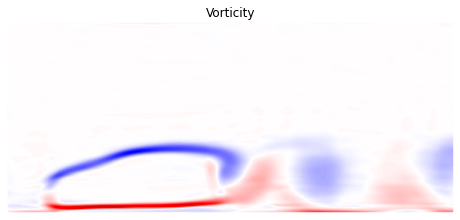

In [52]:
visu_vorticity(vort_init)

and for the optimized latent code:

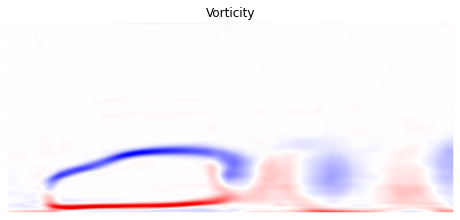

In [53]:
visu_vorticity(vort_final)